# Base System: Basic framework
This tutorial is meant to introduce the very basic functionality of the comfit Python package, including how to initiate a `BaseSystem`, calculating derivatives and plotting.

The class underlying everything is the class called "BaseSystem". Every other model (classes located in the ./models/ folder) are subclasses of BaseSystem. 

If you have not already, start by installing the comfit package. 

In [1]:
#!pip install comfit -q

We start by importing the package.

In [2]:
import sys
from pathlib import Path
current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.append(str(parent_dir))
import comfit as cf


## System initialization and plotting

Now we can define a system with a given dimension and resolution

In [3]:
sys1 = cf.BaseSystem(1,xRes=11)

sys1 is now an instance of the `BaseSystem` class and contains a number of useful parameters and functions. 
We can always see the current state of the system by printing the instance.

In [4]:
print(sys1)

System Dimension: 1
X-Axis Limits: [0, 11.0], Resolution: 11, Delta: 1.0
Current Time: 0, Time Step: 0.1


Now, we can try to do some basic calculating and plotting

In [5]:
import numpy as np

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x/a_0$'>)

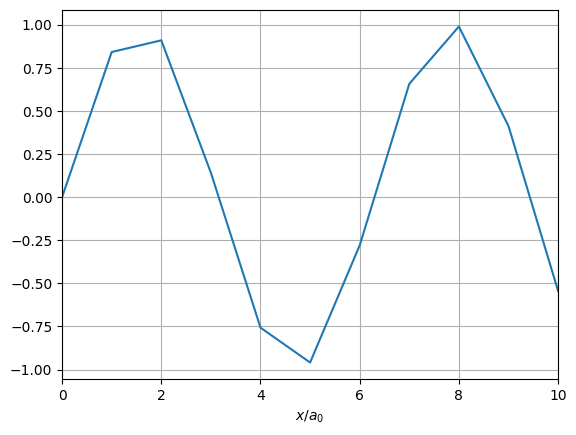

In [6]:
y = np.sin(sys1.x)
sys1.plot_field(y)

In many systems, there is an inherent length scale to the problem and displaying the plots with respect to this length scale makes sense. 
In ComFiT, this length scale is given by the property `a0`. 

Setting a property of a class instance is easy, just write 

```python
sys1.property = value
```

Now, set the property `a0` to $2\pi$ and remake the previous plot. 

<details>
<summary>Solution</summary>
<p>
<pre><code>
sys1.a0 = 2*np.pi
sys1.plot_field(y)
</code></pre>
</p>
</details>


By changing the length scale to $2\pi$, we get something that clearly shows the periodicity. 

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x/a_0$'>)

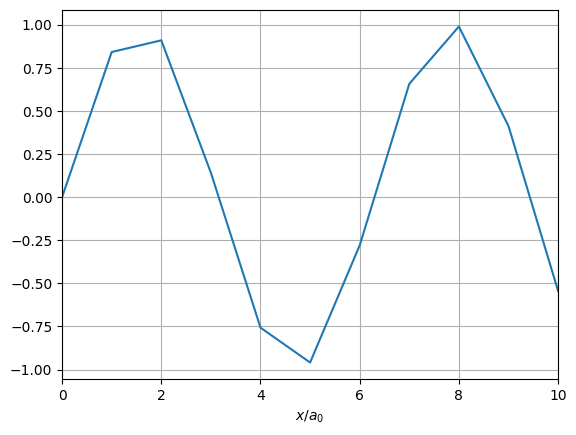

In [7]:

sys1.plot_field(y)

The function looks quite jagged, which we can fix by increasing the resolution and decreasing the interspacing dx

In [8]:
sys2 = cf.BaseSystem(1,xRes=101,dx=0.1)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x/a_0$'>)

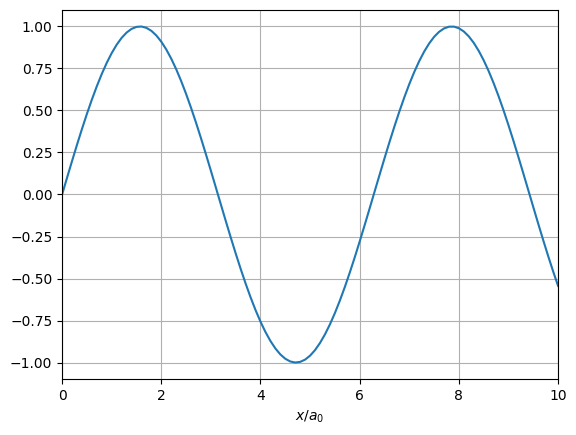

In [9]:
y2 = np.sin(sys2.x)
sys2.plot_field(y2)

Lets have a look at a 2D system and plot a 2D function

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

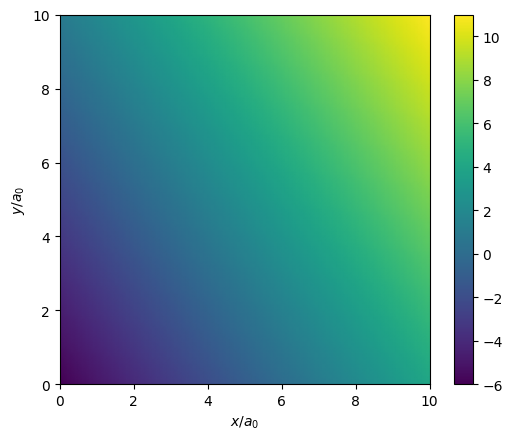

In [10]:
sys2 = cf.BaseSystem(2,xRes=101,dx=0.1,yRes=101,dy=0.1)
field = sys2.x-1 + 0.7*sys2.y-5
sys2.plot_field(field)

As you see, the x-array is stored as a $(xRes,1)$ array, while the y-array is stored as $(1,yRes)$. When doing calculations with arrays in this way, it is not necessary to create a meshgrid to produce a 2D matrix. 

### Exercise 1
Plot the function 
$$
f(x,y) = \sin(x+y)
$$

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

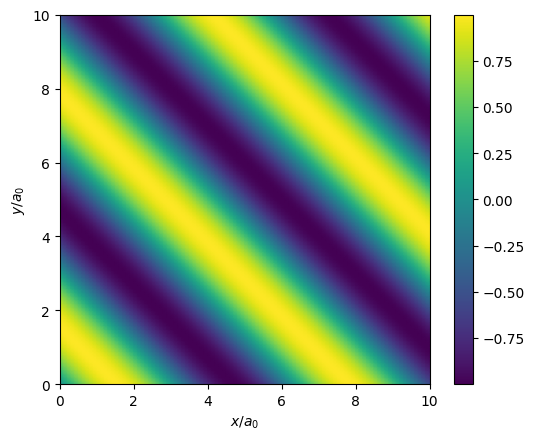

In [11]:
f = np.sin(sys2.x+sys2.y)
sys2.plot_field(f)

### Exercise 2
Plot the function 
$$
f(x,y,z) = exp(-(x^2 + y^2 + z^2))
$$

(<Figure size 640x480 with 2 Axes>,
 <Axes3D: xlabel='$x/a_0$', ylabel='$y/a_0$', zlabel='$z/a_0$'>)

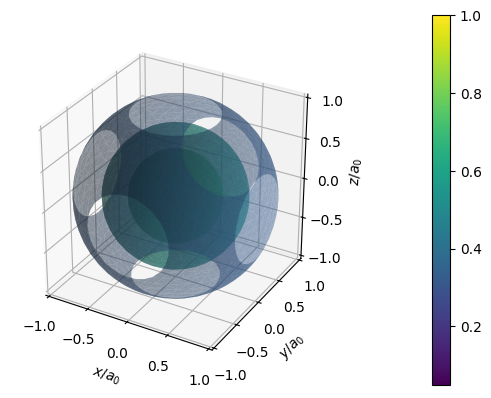

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import comfit as cf

sys3 = cf.BaseSystem(3,
                     xRes=21,dx=0.1, xmin=-1,
                     yRes=21,dy=0.1, ymin=-1,
                     zRes=21,dz=0.1, zmin=-1)
f = np.exp(-sys3.x**2 - sys3.y**2 - sys3.z**2)
sys3.plot_field(f,number_of_layers=3)

## Derivatives

The way that we calculate derivatives in ComFiT is using Fourier transforms. 
We use that 

$$
(\partial_i f )_{\mathfrak f} = \mathfrak i k_i f_{\mathfrak f},
$$

where $f$ is a funciton of real space, $()_{\mathfrak f}$ denotes the Fourier transform of $()$, $\mathfrak i$ is the imaginary unit (`1j` in python), and $k_i$ is the wavevector in the $i$-direction.
The idea then, is to fourier transform $f$, multiply by $\mathfrak i k_i$, and then transform back to real space (note the subtle difference between $i$ and $\mathfrak i$).


As this requires Fourier transforms, we will use the `scipy` package to do the Fourier transforms.

In [13]:
import scipy as sp

Now, let's calculate and plot the derivative of $\sin(x)$.

In [14]:
sys1 = cf.BaseSystem(1, xlim=[0,2*np.pi], xRes=100)

In [15]:
f = np.sin(sys1.x)

In [16]:
dfdx = sp.fft.ifftn(1j*sys1.k[0]*sp.fft.fftn(f))

Lets plot and see

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x/a_0$'>)

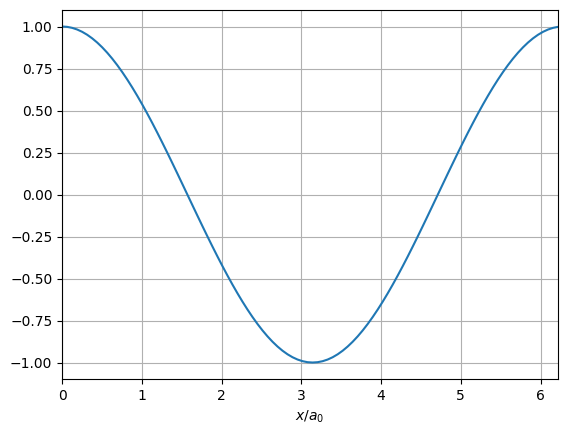

In [17]:
sys1.plot_field(dfdx)

Looks like cosine if you ask me. 

Now, the combination $\mathfrak i k_i$ is often used, so it is defined as a property `dif[i]` in the `BaseSystem` class.

In higher dimensions, derivatives are gradients, so lets calculate the gradient of the 2D function we plotted earlier.

In [18]:
sys2 = cf.BaseSystem(2, xlim=[0,2*np.pi], xRes=100, ylim=[0,2*np.pi], yRes=100)
f = np.sin(sys2.x + sys2.y)
f_f = sp.fft.fftn(f)
gradf = [sp.fft.ifftn(sys2.dif[0]*f_f), sp.fft.ifftn(sys2.dif[1]*f_f)]

The gradient is a vector field, so we need to plot it as such.

Max imaginary part:  3.2364765130099587e-15


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

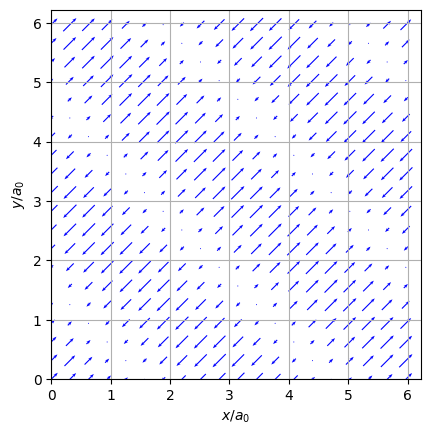

In [19]:
sys2.plot_vector_field(gradf)

Now, you are surely noticing the warning produced in this plot. 
This is because the procedure of fourier transforming and then transforming back to real space is not perfect, and can sometimes lead to small imaginary parts in the result.
This is not a problem, and can be safely ignored.

### Exercise 3
 
Calculate the Laplacian of the 2D function $f(x,y) = \sin(x+y)$ and plot it.

## Animations

ComFiT has a built-in function for creating animations of the system.
This is done by exporting a series of plots and then combining them into a video.
Let's try to create an animation of the 2D function $f(x,y) = \sin(a*x+y)$, where a goes from $0$ to $1$.

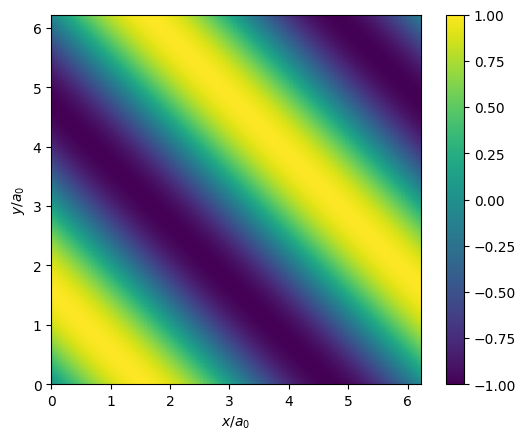

In [21]:

a_values = np.linspace(0,1,100)
for n in range(len(a_values)):
    sys2.plot_field(np.sin(sys2.x + a_values[n]*sys2.y))
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n)

The output animation is saved as `YYMMDD_HHMM - output_animation.gif` in the working directory.